# Train a CNN

In this notebook we will go through all the steps required to train a fully convolutional neural network. Because this takes a while and uses a lot of GPU RAM a separate command line script (`train_nn.py`) is also provided in the `src` directory.

In [2]:
%load_ext autoreload
%autoreload 2
#import sys
#sys.path.insert(0, "/g/data/wb00/admin/testing/weatherbench/notebooks")
#import os
#chdir ("/g/data/wb00/admin/testing/weatherbench/notebooks")
import os
os.chdir("/g/data/wb00/admin/testing/weatherbench/NCI_notebooks/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from src.score import *
from collections import OrderedDict
from dask.diagnostics import ProgressBar
from datetime import datetime
from dask.distributed import Client
client = Client(n_workers=12, threads_per_worker=1)  
client

2024-02-11 05:15:30.487919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been depre

<Client: 'tcp://127.0.0.1:39469' processes=12 threads=12, memory=95.00 GiB>

In [4]:
tf.__version__

'2.13.0'

In [5]:
def limit_mem():
    """By default TF uses all available GPU memory. This function prevents this."""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.compat.v1.Session(config=config)

In [6]:
limit_mem()

2024-02-11 05:15:48.453193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0


In [7]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [8]:
#DATADIR = '/data/WeatherBench/5.625deg/'
#PREDDIR = '/data/WeatherBench/predictions/'
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print(DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print(PREDDIR)
! mkdir -p {PREDDIR} 
! mkdir -p {PREDDIR+"/saved_models"} 
#START = -13
#END   = None
#REF_BASELINE = '/g/data/wb00/admin/testing/weatherbench/dataserv.ub.tum.de/baselines'
#print ("PREDDIR:", PREDDIR)
#print ("REF_BASELINE:", REF_BASELINE)

/g/data/wb00/NCI-Weatherbench/5.625deg
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir


## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [9]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Load the validation subset of the data: 2017 and 2018
#z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
#t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
#with ProgressBar():
z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022')).load() # slice('2017', '2018')) #
#with ProgressBar():    
t850_valid = load_test_data(f'{DATADIR}/temperature/',   't', slice('2021', '2022')).load() #slice('2017', '2018')) #
#with ProgressBar():     
valid = xr.merge([z500_valid, t850_valid]).compute()

[2024-02-11 05:16:03]
var: z
var: t
CPU times: user 17.9 s, sys: 2.36 s, total: 20.3 s
Wall time: 41.1 s


In [10]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
#z = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords')
#t = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').drop('level')
#with ProgressBar():
z = xr.open_mfdataset(get_files_list(f'{DATADIR}/geopotential/'), combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=[500]).load()    
#with ProgressBar():    
t = xr.open_mfdataset(get_files_list(f'{DATADIR}/temperature/'), combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=[850]).drop('level').load()  

[2024-02-11 05:16:44]
CPU times: user 5min 36s, sys: 38.7 s, total: 6min 14s
Wall time: 7min 51s


In [11]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# For the data generator all variables have to be merged into a single dataset.
datasets = [z, t]
ds = xr.merge(datasets).compute()

[2024-02-11 05:24:35]
CPU times: user 5.33 ms, sys: 107 µs, total: 5.44 ms
Wall time: 4.28 ms


In [12]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# In this notebook let's only load a subset of the training data
ds_train = ds.sel(time=slice('1959', '2020'))  #('2015', '2016'))  
ds_test  = ds.sel(time=slice('2021', '2022'))  #('2017', '2018'))

[2024-02-11 05:24:35]
CPU times: user 22.6 ms, sys: 10.3 ms, total: 32.9 ms
Wall time: 24.2 ms


In [13]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time
       
        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            print (f"({var}, {levels})")
            try:
                data.append(ds[var].sel(level=levels))               
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))
            #except KeyError:  
            #    data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [14]:
# then we need a dictionary for all the variables and levels we want to extract from the dataset
#dic = OrderedDict({'z': None, 't': None})
dic = OrderedDict({'z': 500, 't': 500})

In [15]:
bs=32
lead_time=6

In [16]:
ds_train

<xarray.Dataset>
Dimensions:  (level: 1, time: 543504, lat: 32, lon: 64)
Coordinates:
  * level    (level) int32 500
  * time     (time) datetime64[ns] 1959-01-01 ... 2020-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (time, level, lat, lon) float32 4.969e+04 4.972e+04 ... 5.151e+04
    t        (time, level, lat, lon) float32 255.2 255.1 254.9 ... 261.8 261.4

In [17]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
# Create a training and validation data generator. Use the train mean and std for validation as well.
with ProgressBar():
    dg_train = DataGenerator(
        ds_train.sel(time=slice('1959', '2015')), dic, lead_time, batch_size=bs, load=True)
with ProgressBar():    
    dg_valid = DataGenerator(
        ds_train.sel(time=slice('2016', '2020')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

[2024-02-11 05:24:36]
(z, 500)
(t, 500)
Loading data into RAM
(z, 500)
(t, 500)
Loading data into RAM
CPU times: user 1min 55s, sys: 1min 41s, total: 3min 37s
Wall time: 2min 52s


In [18]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 2)>
 array([54072.29  ,   274.3925], dtype=float32)
 Coordinates:
   * level    (level) int32 500 500,
 <xarray.DataArray 'z' (level: 2)>
 array([1119.3583  ,    5.773593], dtype=float32)
 Coordinates:
   * level    (level) int32 500 500)

In [19]:
%%time
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

(z, 500)
(t, 500)
Loading data into RAM
CPU times: user 4.9 s, sys: 23.3 s, total: 28.2 s
Wall time: 22.3 s


## Create and train model

Next up, we need to create the model architecture. Here we will use a fully connected convolutional network. Because the Earth is periodic in longitude, we want to use a periodic convolution in the lon-direction. This is not implemented in Keras, so we have to do it manually.

In [20]:
class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config


class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config

In [21]:
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        if dr > 0: x = Dropout(dr)(x)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

In [22]:
import tensorflow as tf
from keras import backend as K
print(K.backend())
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU')) 


tensorflow
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 2))

2024-02-11 05:27:51.634329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b1:00.0, compute capability: 7.0


CPU times: user 307 ms, sys: 217 ms, total: 524 ms
Wall time: 775 ms


In [25]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )
cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

[2024-02-11 05:27:52]
CPU times: user 11.6 ms, sys: 770 µs, total: 12.4 ms
Wall time: 10.7 ms


In [24]:
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 periodic_conv2d (PeriodicC  (None, 32, 64, 64)        3264      
 onv2D)                                                          
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 64, 64)        0         
                                                                 
 periodic_conv2d_1 (Periodi  (None, 32, 64, 64)        102464    
 cConv2D)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 64, 64)        0         
                                                                 
 periodic_conv2d_2 (Periodi  (None, 32, 64, 64)        102464

In [26]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Since we didn't load the full data this is only for demonstration.
cnn.fit(dg_train, epochs=100, validation_data=dg_valid, 
          callbacks=[tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=0,
                        patience=3,
                        verbose=1, 
                        mode='auto'
                    )]
         )

[2024-02-11 05:27:52]
Epoch 1/100


2024-02-11 05:27:53.963383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-11 05:27:56.402701: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14557b5a1710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-11 05:27:56.402733: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-02-11 05:27:56.578903: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-11 05:27:57.143051: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15615/15615 [==============================] - 225s 14ms/step - loss: 0.0467 - val_loss: 0.0334
Epoch 2/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0327 - val_loss: 0.0302
Epoch 3/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0309 - val_loss: 0.0290
Epoch 4/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0299 - val_loss: 0.0281
Epoch 5/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0291 - val_loss: 0.0276
Epoch 6/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0285 - val_loss: 0.0270
Epoch 7/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0280 - val_loss: 0.0267
Epoch 8/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0276 - val_loss: 0.0262
Epoch 9/100
15615/15615 [==============================] - 219s 14ms/step - loss: 0.0272 - val_loss: 0.0258
Epoch 10/100
15615/15615 [==============

In [26]:
# cnn.save_weights('/home/rasp/cube_home/tmp/test.h5')

In [27]:
# Load weights from externally trained model
#cnn.load_weights('/data/weather-benchmark/predictions/saved_models/fccnn_6h.h5')
#cnn.load_weights(f'{REF_BASELINE}/saved_models/fccnn_6h.h5')


## Create predictions

Now that we have our model we need to create a prediction NetCDF file. This function does this. 

We can either directly predict the target lead time (e.g. 5 days) or create an iterative forecast by chaining together many e.g. 6h forecasts.

In [27]:
def create_predictions(model, dg):
    """Create predictions for non-iterative model"""
    preds = model.predict_generator(dg)
    # Unnormalize
    preds = preds * dg.std.values + dg.mean.values
    fcs = []
    lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None or isinstance(levels, int):
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx],
                dims=['time', 'lat', 'lon'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            fcs.append(xr.DataArray(
                preds[:, :, :, lev_idx:lev_idx+nlevs],
                dims=['time', 'lat', 'lon', 'level'],
                coords={'time': dg.valid_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(fcs)

In [28]:
%%time

print( f'[{datetime.now().replace(microsecond=0)}]' )
fc = create_predictions(cnn, dg_test)

[2024-02-11 08:04:58]
CPU times: user 9.3 s, sys: 11.2 s, total: 20.5 s
Wall time: 14.4 s


In [29]:
print( valid['time'])
print(    fc['time'])

<xarray.DataArray 'time' (time: 17520)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
<xarray.DataArray 'time' (time: 17514)>
array(['2021-01-01T06:00:00.000000000', '2021-01-01T07:00:00.000000000',
       '2021-01-01T08:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01T06:00:00 ... 2022-12-31T23:00:00


In [30]:
%%time
rmse_1 = compute_weighted_rmse(fc, valid).compute()
print (rmse_1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 95.14
    t        float64 1.063
CPU times: user 1.74 s, sys: 4.62 s, total: 6.36 s
Wall time: 4.87 s


In [31]:
def create_iterative_predictions(model, dg, max_lead_time=5*24):
    state = dg.data[:dg.n_samples]
    preds = []
    for _ in range(max_lead_time // dg.lead_time):
        state = model.predict(state)
        p = state * dg.std.values + dg.mean.values
        preds.append(p)
    preds = np.array(preds)
    
    lead_time = np.arange(dg.lead_time, max_lead_time + dg.lead_time, dg.lead_time)
    das = []; lev_idx = 0
    for var, levels in dg.var_dict.items():
        if levels is None or isinstance(levels, int):
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx],
                dims=['lead_time', 'time', 'lat', 'lon'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon},
                name=var
            ))
            lev_idx += 1
        else:
            nlevs = len(levels)
            das.append(xr.DataArray(
                preds[:, :, :, :, lev_idx:lev_idx+nlevs],
                dims=['lead_time', 'time', 'lat', 'lon', 'level'],
                coords={'lead_time': lead_time, 'time': dg.init_time, 'lat': dg.ds.lat, 'lon': dg.ds.lon, 'level': levels},
                name=var
            ))
            lev_idx += nlevs
    return xr.merge(das)

In [32]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

fc_iter = create_iterative_predictions(cnn, dg_test)

[2024-02-11 08:05:18]
548/548 [==============================] - 3s 5ms/step
CPU times: user 1min 56s, sys: 1min 17s, total: 3min 13s
Wall time: 2min 27s


In [33]:
print (fc_iter['time'])
print (  valid['time'])

<xarray.DataArray 'time' (time: 17514)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T15:00:00.000000000',
       '2022-12-31T16:00:00.000000000', '2022-12-31T17:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
<xarray.DataArray 'time' (time: 17520)>
array(['2021-01-01T00:00:00.000000000', '2021-01-01T01:00:00.000000000',
       '2021-01-01T02:00:00.000000000', ..., '2022-12-31T21:00:00.000000000',
       '2022-12-31T22:00:00.000000000', '2022-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00


In [34]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

#rmse = evaluate_iterative_forecast(fc_iter, valid)
rmse_z_t = evaluate_iterative_forecast(fc_iter, valid, compute_weighted_rmse)

[2024-02-11 08:07:45]
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 6
Data variables:
    z          float64 95.14
    t          float64 1.063, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 12
Data variables:
    z          float64 146.3
    t          float64 1.39, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 18
Data variables:
    z          float64 202.1
    t          float64 1.6, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 24
Data variables:
    z          float64 259.7
    t          float64 1.767, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 30
Data variables:
    z          float64 323.6
    t          float64 1.957, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 36
Data variables:
    z          float64 389.6
    t          float64 2.157, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 42
Data variables:
    z       

In [35]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

rmse_z_t.load()

[2024-02-11 08:09:49]
CPU times: user 346 µs, sys: 54 µs, total: 400 µs
Wall time: 334 µs


<xarray.Dataset>
Dimensions:    (lead_time: 20)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time) float64 95.14 146.3 202.1 ... 1.109e+03 1.154e+03
    t          (lead_time) float64 1.063 1.39 1.6 1.767 ... 4.665 4.84 5.001

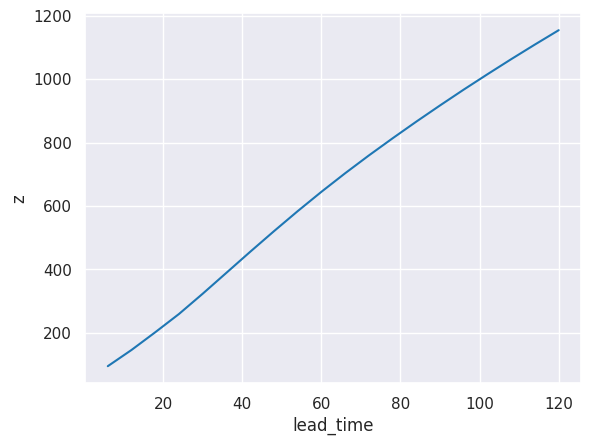

In [36]:
rmse_z_t.z.plot()

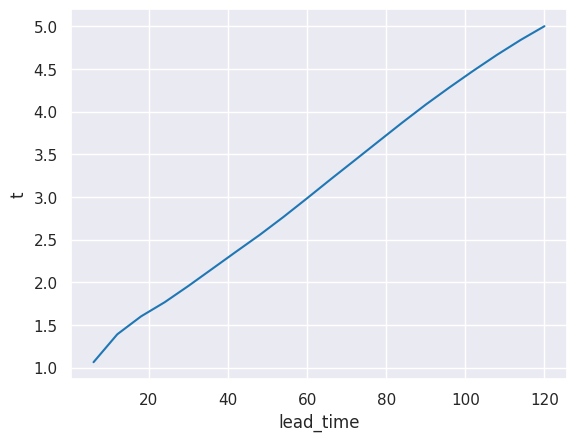

In [37]:
rmse_z_t.t.plot()

In [ ]:
#rmse.z_rmse.plot()

In [ ]:
#rmse.t_rmse.plot()

# The end